In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict, train_test_split
from lightgbm import LGBMRegressor


In [2]:
data = pd.read_csv('./data/daily_restaurant_sales.csv')
train, test = train_test_split(data, test_size=0.25)

In [4]:
X = ["month", "weeday", "is_holiday", "competitors_price"]
T = "discounts"
y = "sales"
debias_m = LGBMRegressor()
denoise_m = LGBMRegressor()
t_res =  train[T] - cross_val_predict(debias_m, train[X], train[T], cv=5)
y_res =  train[y] - cross_val_predict(denoise_m, train[X], train[y], cv=5)
         

# Treatment effects

In [5]:
import statsmodels.api as sm

sm.OLS(y_res, t_res).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
discounts,31.6507,0.136,231.882,0.000,31.383,31.918


# Double ML for CATE estimation

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mrow>
    <msub><mover accent="true"><mi>L</mi> <mo>^</mo></mover> <mi>n</mi> </msub>
    <mrow>
      <mo>(</mo>
      <mi>τ</mi>
      <mrow>
        <mo>(</mo>
        <mi>x</mi>
        <mo>)</mo>
      </mrow>
      <mo>)</mo>
    </mrow>
    <mo>=</mo>
    <mfrac><mn>1</mn> <mi>n</mi></mfrac>
    <munderover><mo>∑</mo> <mrow><mi>i</mi><mo>=</mo><mn>1</mn></mrow> <mi>n</mi> </munderover>
    <msubsup><mover accent="true"><mi>T</mi> <mo>˜</mo></mover> <mi>i</mi> <mn>2</mn> </msubsup>
    <msup><mfenced separators="" open="(" close=")"><mfrac><msub><mover accent="true"><mi>Y</mi> <mo>˜</mo></mover> <mi>i</mi> </msub> <msub><mover accent="true"><mi>T</mi> <mo>˜</mo></mover> <mi>i</mi> </msub></mfrac><mo>-</mo><mi>τ</mi><mrow><mo>(</mo><msub><mi>X</mi> <mi>i</mi> </msub><mo>)</mo></mrow></mfenced> <mn>2</mn> </msup>
  </mrow>
</math>

In [7]:
y_star = y_res/t_res
w = t_res**2
cate_model = LGBMRegressor().fit(train[X], y_star, sample_weight=w)
test_r_learner_pred = test.assign(cate = cate_model.predict(test[X]))

<AxesSubplot:xlabel='discounts', ylabel='Density'>

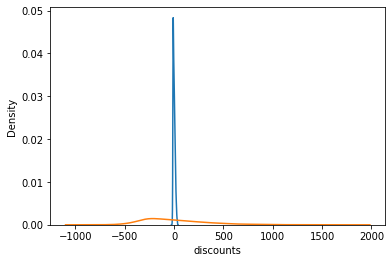

In [9]:
sns.kdeplot(t_res)
sns.kdeplot(y_res)

In [8]:
test_r_learner_pred

,rest_id,day,month,weeday,weekend,is_holiday,is_dec,is_nov,competitors_price,discounts,sales,cate
869,0,5/19/2018,5,5,True,False,False,False,3.51,0,51.0,36.416645
3709,3,2/22/2017,2,2,False,False,False,False,5.88,15,449.5,27.075252
1684,1,8/10/2017,8,3,False,False,False,False,3.53,10,379.0,34.931657
535,0,6/19/2017,6,0,False,False,False,False,5.43,30,600.0,26.285649
2970,2,2/15/2018,2,3,False,False,False,False,5.39,30,1172.0,33.233101
...,...,...,...,...,...,...,...,...,...,...,...,...
1004,0,10/1/2018,10,0,False,False,False,False,6.57,40,1059.0,29.636657
451,0,3/27/2017,3,0,False,False,False,False,5.75,15,429.0,28.486966
2260,2,3/7/2016,3,0,False,False,False,False,9.17,0,36.0,18.379234
5808,5,11/19/2016,11,5,True,False,False,True,6.02,15,607.0,35.185523


In [10]:
import statsmodels.formula.api as smf

smf.ols("y_res~t_res", data=df_res).fit().params["t_res"]

NameError: name 'df_res' is not defined